<a href="https://colab.research.google.com/github/sisiliaanggraini/Breast-Cancer-Detection/blob/main/Prapemrosesan_Citra_%5B3%5D_Pectoral_Muscle_Removal_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] Import Libraries

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import pylab as pylab
import math

from scipy import ndimage as ndi
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon

# [2] Directory

In [ ]:
#1st_process (sudah disortir, jangan diutak atik)
dir_1st_process_c = '/content/drive/MyDrive/Hasil Preprocessing Dataset/[1] Background Removal/Cancer'
dir_1st_process_n = '/content/drive/MyDrive/Hasil Preprocessing Dataset/[1] Background Removal/Normal'

# [3] Edge Detection

In [ ]:
def clahe(image):
    if image.dtype == np.float32:
        image = (image * 255).astype('uint8')
    elif image.dtype == np.uint16:
        image = (image / 256).astype('uint8')
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    clahe_img = clahe.apply(image)
    return clahe_img


def contrast_stretching(image, a=20, b=210):
    stretched_img = np.interp(image, (a,b), (0,255)).astype('uint8')
    return stretched_img

In [ ]:
def right_orient_mammogram(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    if left_nonzero < right_nonzero:
        image = cv2.flip(image, 1)

    return image

def resize(image, height=256, width=256):
    resized_image = np.zeros((height, width), dtype=np.float32)
    M, N = image.shape
    y_scale = height / float(M)
    x_scale = width / float(N)
    for i in range(height):
        for j in range(width):
            y = int(i / y_scale)
            x = int(j / x_scale)
            resized_image[i, j] = image[y, x]
    return resized_image

In [ ]:
def normalisasi(image):
    norm = (image - np.min(image)) / (np.max(image) - np.min(image))
    norm = np.clip(norm, 0, 1)
    normal = (norm * 255).astype(np.uint8)
    return normal

def sobel_filter(image):
    sobel_ax0 = ndi.sobel(image, axis=0)
    sobel_ax1 = ndi.sobel(image, axis=1)
    edges = np.sqrt(sobel_ax0 ** 2 + sobel_ax1 ** 2)
    edges_norm = normalisasi(edges)
    return edges_norm

def apply_canny(image):
    canny_img = canny(image, 5)
    return canny_img

# [4]Hough Transform

In [ ]:
def get_hough_lines(canny_norm):
    h, theta, d = hough_line(canny_norm)
    lines = list()
    #print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        #print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_norm.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })

    return lines

In [ ]:
def shortlist_lines(lines):
    MIN_ANGLE = 15
    MAX_ANGLE = 75
    MIN_DIST  = 5
    MAX_DIST  = 256

    shortlisted_lines = [x for x in lines if
                          (x["dist"]>=MIN_DIST) &
                          (x["dist"]<=MAX_DIST) &
                          (x["angle"]>=MIN_ANGLE) &
                          (x["angle"]<=MAX_ANGLE)
                        ]
    print('jumlah:', len(shortlisted_lines))
    #print('\nShorlisted lines')
    #for i in shortlisted_lines:
        #print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))

    return shortlisted_lines

In [ ]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])

    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)

    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

# Display Result Pectoral Removed

In [ ]:
file_list = os.listdir(dir_1st_process_c)
file_list.sort()

success_count = 0
fail_count = 0

for filename in (file_list):
    try:
        if filename.endswith('_MLO.png'):
            image_path = os.path.join(dir_1st_process_c, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            result_7th = clahe(img)
            result_8th = contrast_stretching(result_7th)
            result_9th = right_orient_mammogram(result_8th)
            image = resize(result_9th)
            canny_img = apply_canny(image)
            sobel_img = sobel_filter(canny_img)
            lines = get_hough_lines(sobel_img)
            shortlisted_lines = shortlist_lines(lines)

            fig, axes = plt.subplots(1, 6, figsize=(15,5))
            fig.tight_layout(pad=1.0)
            #fig.suptitle(os.path.basename(filename))
            axes[0].set_title(''+ filename)
            axes[0].imshow(image, cmap=pylab.cm.gray)
            axes[0].axis('off')

            axes[1].set_title('Canny Edge')
            axes[1].imshow(canny_img, cmap=pylab.cm.gray)
            axes[1].axis('off')

            axes[2].set_title('Sobel Filter')
            axes[2].imshow(sobel_img, cmap=pylab.cm.gray)
            axes[2].axis('off')

            axes[3].set_title('Hough Lines')
            axes[3].imshow(sobel_img, cmap=pylab.cm.gray)
            axes[3].axis('on')
            axes[3].set_xlim(0,sobel_img.shape[1])
            axes[3].set_ylim(sobel_img.shape[0])
            for line in lines:
                axes[3].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')

            axes[4].set_title('Shortlisted Lines')
            axes[4].imshow(sobel_img, cmap=pylab.cm.gray)
            axes[4].axis('on')
            axes[4].set_xlim(0,sobel_img.shape[1])
            axes[4].set_ylim(sobel_img.shape[0])
            for line in shortlisted_lines:
                axes[4].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')

            rr, cc = remove_pectoral(shortlisted_lines)
            image[rr, cc] = 0
            axes[5].set_title('Pectoral muscle removed')
            axes[5].imshow(image, cmap=pylab.cm.gray)
            axes[5].axis('on')
            plt.show()

            success_count += 1
    except IndexError:
        fail_count += 1
        print(f"Error: file {filename} cannot be processed.")
        continue

print(f"Total citra berhasil diproses: {success_count}")
print(f"Total citra gagal diproses: {fail_count}")

In [ ]:
file_list = os.listdir(dir_1st_process_n)
file_list.sort()

success_count = 0
fail_count = 0

for filename in (file_list):
    try:
        if filename.endswith('_MLO.png'):
            image_path = os.path.join(dir_1st_process_n, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            result_7th = clahe(img)
            result_8th = contrast_stretching(result_7th)
            result_9th = right_orient_mammogram(result_8th)
            image = resize(result_9th)
            canny_img = apply_canny(image)
            sobel_img = sobel_filter(canny_img)
            lines = get_hough_lines(sobel_img)
            shortlisted_lines = shortlist_lines(lines)

            fig, axes = plt.subplots(1, 6, figsize=(15,5))
            fig.tight_layout(pad=1.0)
            #fig.suptitle(os.path.basename(filename))
            axes[0].set_title(''+ filename)
            axes[0].imshow(image, cmap=pylab.cm.gray)
            axes[0].axis('off')

            axes[1].set_title('Canny Edge')
            axes[1].imshow(canny_img, cmap=pylab.cm.gray)
            axes[1].axis('off')

            axes[2].set_title('Sobel Filter')
            axes[2].imshow(sobel_img, cmap=pylab.cm.gray)
            axes[2].axis('off')

            axes[3].set_title('Hough Lines')
            axes[3].imshow(sobel_img, cmap=pylab.cm.gray)
            axes[3].axis('on')
            axes[3].set_xlim(0,sobel_img.shape[1])
            axes[3].set_ylim(sobel_img.shape[0])
            for line in lines:
                axes[3].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')

            axes[4].set_title('Shortlisted Lines')
            axes[4].imshow(sobel_img, cmap=pylab.cm.gray)
            axes[4].axis('on')
            axes[4].set_xlim(0,sobel_img.shape[1])
            axes[4].set_ylim(sobel_img.shape[0])
            for line in shortlisted_lines:
                axes[4].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')

            rr, cc = remove_pectoral(shortlisted_lines)
            image[rr, cc] = 0
            axes[5].set_title('Pectoral muscle removed')
            axes[5].imshow(image, cmap=pylab.cm.gray)
            axes[5].axis('on')
            plt.show()

            success_count += 1
    except IndexError:
        fail_count += 1
        print(f"Error: file {filename} cannot be processed.")
        continue

print(f"Total citra berhasil diproses: {success_count}")
print(f"Total citra gagal diproses: {fail_count}")

# Cek citra gagal

<ipython-input-154-e9dc78321998>:8: RuntimeWarning: divide by zero encountered in double_scalars
  y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
<ipython-input-154-e9dc78321998>:10: RuntimeWarning: divide by zero encountered in double_scalars
  y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)


jumlah: 8


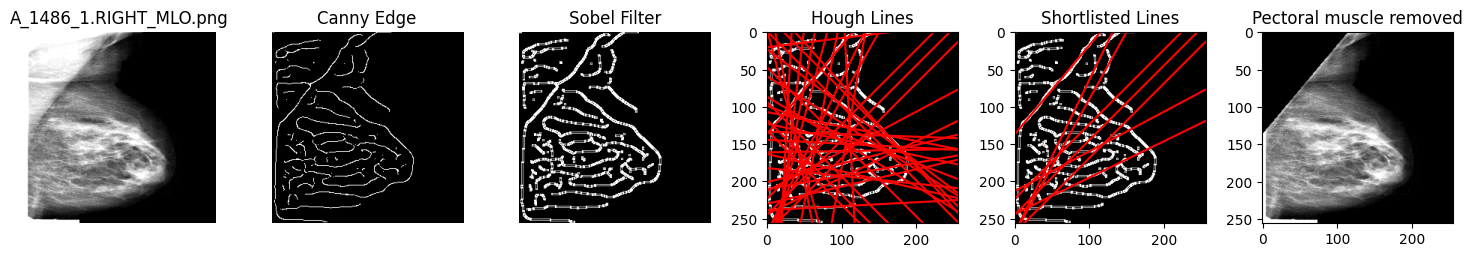

In [ ]:
image_path = '/content/drive/MyDrive/Hasil Preprocessing Dataset/[1] Background Removal/Cancer/A_1486_1.RIGHT_MLO.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
result_7th = clahe(img)
result_8th = contrast_stretching(result_7th)
result_9th = right_orient_mammogram(result_8th)
image = resize(result_9th)
canny_img = apply_canny(image)
sobel_img = sobel_filter(canny_img)
lines = get_hough_lines(sobel_img)
shortlisted_lines = shortlist_lines(lines)

fig, axes = plt.subplots(1, 6, figsize=(15,5))
fig.tight_layout(pad=1.0)
#fig.suptitle(os.path.basename(filename))
axes[0].set_title(''+ filename)
axes[0].imshow(image, cmap=pylab.cm.gray)
axes[0].axis('off')

axes[1].set_title('Canny Edge')
axes[1].imshow(canny_img, cmap=pylab.cm.gray)
axes[1].axis('off')

axes[2].set_title('Sobel Filter')
axes[2].imshow(sobel_img, cmap=pylab.cm.gray)
axes[2].axis('off')

axes[3].set_title('Hough Lines')
axes[3].imshow(sobel_img, cmap=pylab.cm.gray)
axes[3].axis('on')
axes[3].set_xlim(0,sobel_img.shape[1])
axes[3].set_ylim(sobel_img.shape[0])
for line in lines:
    axes[3].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')

axes[4].set_title('Shortlisted Lines')
axes[4].imshow(sobel_img, cmap=pylab.cm.gray)
axes[4].axis('on')
axes[4].set_xlim(0,sobel_img.shape[1])
axes[4].set_ylim(sobel_img.shape[0])
for line in shortlisted_lines:
    axes[4].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')

rr, cc = remove_pectoral(shortlisted_lines)
image[rr, cc] = 0
axes[5].set_title('Pectoral muscle removed')
axes[5].imshow(image, cmap=pylab.cm.gray)
axes[5].axis('on')
plt.show()

# [6] Evaluasi Performance

In [ ]:
def mean_square_error(before, after):
    mse = np.mean((before-after) ** 2)
    return mse

def peak_signal_noise_ratio(before, after):
    mse = mean_square_error(before, after)
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr